---
title: "Building ReAct agents with (and without) LangGraph"
date: 2025-07-04
description-meta: "How to build ReAct agents from scratch with (and without) LangGraph"
categories:
  - llm
  - python
  - anthropic
  - openai
  - agents
---

As Large Language Models (LLMs) have become more powerful, I've started to see increasing interest from clients in building agents.

The problem is that most of the use cases clients have in mind for agents are better suited for [agentic workflows](https://dylancastillo.co/posts/agentic-workflows-langgraph.html). Agents are a good fit for tasks without a predefined path and where the order of steps is not known beforehand. Agentic workflows, on the other hand, are the right choice for tasks where both of these things are known. 

Nonetheless, agents are still a good fit for many use cases, such as coding assistants and support agents. You should definitely spend some time learning about them.

In this post, I'll show you how to build a Reasoning and Acting (ReAct) agent with (and without) LangGraph.

Let's start by defining some key concepts.

## What is an agent?

The biggest players in the ecosystem have converged on similar definitions of what constitutes an "agent." [Anthropic](https://www.anthropic.com/engineering/building-effective-agents) describes them as systems where LLMs "dynamically direct their own processes and tool usage," while [OpenAI](https://openai.com/index/new-tools-for-building-agents/) calls them "systems that independently accomplish tasks on behalf of users." [LangChain](https://blog.langchain.com/what-is-an-agent/) similarly defines them as systems using an LLM to "decide the control flow of an application."

In essence, agents are systems that can independently make decisions, use tools, take actions, and pursue a goal without direct human guidance. The most well-known agent implementation are *ReAct Agents*. 

## What's a ReAct agent?

[ReAct (Reasoning and Acting) Agents](https://arxiv.org/abs/2210.03629) are AI systems that merge the reasoning of Large Language Models (LLMs) with the ability to perform actions. They follow an iterative "think, act, observe" cycle to solve problems and achieve user goals. For example, a ReAct agent would:

1. Take a user query.
2. Think about the query and decide on an action.
3. Execute the action using available tools (environment).
4. Analyzes the result of that action (environment).
5. Continues the "Reason, Act, Observe" loop until it reaches the final answer.

Here's a diagram of a ReAct agent:

```{mermaid}
graph LR
    Human <--> LLM[LLM]
    LLM -->|Action| Environment
    Environment -->|Feedback| LLM
    LLM -.-> Stop
```


The first generation of ReAct agents used a prompt technique of "Thought, Action, Observation". Current agents rely on [function-calling](https://dylancastillo.co/posts/function-calling-structured-outputs.html) to implement the "think, act, observe" loop.

## What is LangGraph?

LangGraph is a graph-based framework for building complex LLM applications, designed for stateful workflows. It makes it easier to build complex agent architectures.

Graphs are composed of nodes, edges, state, and reducers. Nodes are the units of work (functions, tools) and edges define the paths between nodes. State is persistent data passed between nodes and updated through reducers (functions that define how the state is updated).

I like LangGraph because it provides you with easy-to-use components, a simple API, and it lets you visualize your workflow. It also integrates well with LangSmith, a tool for monitoring and debugging LLM applications.

In this tutorial, I'll show you how to build a ReAct agent with (and without) LangGraph. I'll also use *LangChain* as a thin wrapper on top of OpenAI models.

## Prerequisites

To follow this tutorial you'll need to:

1. Sign up and generate an API key in [OpenAI](https://platform.openai.com/docs/overview).
2. Set the API key as an environment variable called `OPENAI_API_KEY`.
3. Create a virtual environment in Python and install the requirements:

```bash
python -m venv venv
source venv/bin/activate
pip install langchain langchain-openai langchain-community langgraph jupyter
```

Once you've completed the steps above, you can run the code from this article. You can also download the notebook from [here](https://github.com/dylanjcastillo/blog/tree/main/posts/react-agent-langgraph.ipynb).

## Implementation

As usual, you must start by importing the necessary libraries and loading the environment variables. You'll use the same model in all the examples, so you'll define it once here: 

In [1]:
from typing import Literal

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph

load_dotenv()

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

This code: 

1. Imports the necessary libraries. 
2. Loads environment variables from a `.env` file using `load_dotenv()`. 
3. Defines a model (`gpt-4.1-mini`) that you'll use in all the examples.

### Vanilla ReAct agent

You'll build an agent that takes a question from a user and has access to a a tool. The tool is a Python REPL that it can use to answer the question. 

**You should not use this in production**. This tool can run arbitrary Python code on your device, and that's not something you want to expose to random people on the internet.

First, let's define the `run_python_code` tool.

In [2]:
@tool
def run_python_code(code: str) -> str:
    """Run arbitrary Python code including imports, assignments, and statements. Do not use any external libraries. Save your results as a variable.

    Args:
        code: Python code to run
    """
    import sys
    from io import StringIO

    old_stdout = sys.stdout
    sys.stdout = captured_output = StringIO()

    namespace = {}

    try:
        exec(code, namespace)

        output = captured_output.getvalue()

        if not output.strip():
            user_vars = {
                k: v
                for k, v in namespace.items()
                if not k.startswith("__") and k not in ["StringIO", "sys"]
            }
            if user_vars:
                if len(user_vars) == 1:
                    output = str(list(user_vars.values())[0])
                else:
                    output = str(user_vars)

        return output.strip() if output.strip() else "Code executed successfully"

    except Exception as e:
        return f"Error: {str(e)}"
    finally:
        sys.stdout = old_stdout


tools = [run_python_code]
tools_mapping = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

This code defines a tool. In `LangChain` tools are defined as functions decorated with `@tool`. These functions must have a *docstring* because it will be used to describe the tool to the LLM. 

`run_python_code` is a function that takes a code string and returns the result of executing that code.

Next, you provide the model with a mapping of the tool to its name by creating `tools_mapping`. This is often a point of confusion. The LLM doesn't run the tools on its own. It only decides if a tool should be used. Then, your own code must make the actual tool call. 

The mapping is more useful when there are multiple tools, and not a single tool, like in this case. However, I'm showing it here to illustrate how you'd usually do this in a real-world application.

Finally, you _bind_ the tool to the model. The binding makes the model aware of the tool, so that it can use it. 

Then, let's define a function that encapsulates the logic of the agent.

In [3]:
def run_agent(question: str):
    messages = [
        SystemMessage(
            "You're a helpful assistant. Use the tools provided when relevant."
        ),
        HumanMessage(question),
    ]
    ai_message = model_with_tools.invoke(messages)
    messages.append(ai_message)

    while ai_message.tool_calls:
        for tool_call in ai_message.tool_calls:
            selected_tool = tools_mapping[tool_call["name"]]
            tool_msg = selected_tool.invoke(tool_call)
            messages.append(tool_msg)
        ai_message = model_with_tools.invoke(messages)
        messages.append(ai_message)

    return messages

This function takes a question from a user, comes up with a python script, uses `run_python_code` to execute it and returns the result.

It works as follows:

- **Lines 2 to 9** set up the [prompts](https://dylancastillo.co/posts/prompt-engineering-101.html) and call the assistant. 
- **Lines 11 to 17** is where the magic happens. This is a loop that will check if there's been a tool call in the response from the model. If there is, it will call (invoke) the tool and add the result to the messages. It will then send the results back to the assistant, and repeat this process until there are no more tool calls.

This is the core idea behind how agents work. You provide the assistant with a question and one or more tools. Then you let the assistant decide which tool to use, until it has all the information it needs to answer the question.

You can try it out by running the following code:

In [4]:
messages = run_agent("Generate 10 random numbers between 1 and 100")

for m in messages:
    m.pretty_print()

================================ System Message ================================

You're a helpful assistant. Use the tools provided when relevant.
================================ Human Message =================================

Generate 10 random numbers between 1 and 100
================================== Ai Message ==================================
Tool Calls:
  run_python_code (call_twMJ1JkZK81ofm3842P3jNtb)
 Call ID: call_twMJ1JkZK81ofm3842P3jNtb
  Args:
    code: import random
random_numbers = [random.randint(1, 100) for _ in range(10)]
random_numbers
================================= Tool Message =================================
Name: run_python_code

{'random': <module 'random' from '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/random.py'>, 'random_numbers': [74, 75, 58, 19, 90, 45, 44, 52, 90, 33]}
================================== Ai Message ==================================

Here are 10 random numbers between 1 and 100

You can see that the agent took the user's request, used the `run_python_code` tool to generate the numbers, and then returned the result.

Now, let's see how you can build a ReAct agent with LangGraph.

### LangGraph ReAct agent

Like, in the previous example, you start by defining the tools you want to use. You'll use the same `run_python_code` tool.

In [5]:
@tool
def run_python_code(code: str) -> str:
    """Run arbitrary Python code including imports, assignments, and statements. Do not use any external libraries. Save your results as a variable.

    Args:
        code: Python code to run
    """
    import sys
    from io import StringIO

    old_stdout = sys.stdout
    sys.stdout = captured_output = StringIO()

    namespace = {}

    try:
        exec(code, namespace)

        output = captured_output.getvalue()

        if not output.strip():
            user_vars = {
                k: v
                for k, v in namespace.items()
                if not k.startswith("__") and k not in ["StringIO", "sys"]
            }
            if user_vars:
                if len(user_vars) == 1:
                    output = str(list(user_vars.values())[0])
                else:
                    output = str(user_vars)

        return output.strip() if output.strip() else "Code executed successfully"

    except Exception as e:
        return f"Error: {str(e)}"
    finally:
        sys.stdout = old_stdout


tools = [run_python_code]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

With langgraph you also need to you define the tools in the same way: set up the functions, add `@tool`, and create the tool mapping. Then, *bind* the tools to the model.

Next, you need to define the functions (nodes) that correspond to the steps the agent will take: 

In [6]:
def call_llm(state: MessagesState):
    messages = [
        SystemMessage(content="You are a helpful assistant that can run python code."),
    ] + state["messages"]
    return {"messages": [model_with_tools.invoke(messages)]}


def call_tool(state: MessagesState):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["environment", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END

This is how it works:

1. `call_llm`: Sends the conversation history to the LLM to get the next response.
2. `call_tool`: If the LLM's response is a request to use a tool, this function executes the tool with the specified arguments.
3. `should_continue`: This is the control logic. It checks the LLM's last message. If it's a tool request, it routes to the `call_tool`; otherwise, it ends the conversation.

`call_llm` and `call_tool` take `MessagesState` as input and return a the message key with the new message. This updates the `messages` key in the `MessagesState`. `should_continue` takes `MessagesState` act as a router, so it decides if a tool should be executed or if the conversation should end.

In [7]:
agent_builder = StateGraph(MessagesState)

agent_builder.add_node("llm", call_llm)
agent_builder.add_node("environment", call_tool)

agent_builder.add_edge(START, "llm")
agent_builder.add_conditional_edges(
    "llm",
    should_continue,
    {
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm")

agent = agent_builder.compile()

This code sets up the logic of the agent. It starts with a call to the LLM. The LLM then decides whether to use a tool or to finish the task. If it uses a tool, the tool's output is sent back to the LLM for the next step. This "think-act" loop continues until the agent decides the task is complete.

You can use `LangGraph` to visualize the agent's flow:

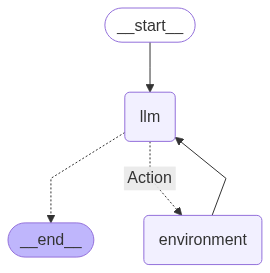

In [8]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Finally, you can run the agent by invoking the graph. For that, you'll need to pass a list of messages to the graph.

In [9]:
messages = [
    SystemMessage(content="You are a helpful assistant that can run python code."),
    HumanMessage(content="Generate 10 random numbers between 1 and 100"),
]

messages = agent.invoke({"messages": messages})

You can review the process by printing the messages:

In [10]:
for m in messages["messages"]:
    m.pretty_print()

================================ System Message ================================

You are a helpful assistant that can run python code.
================================ Human Message =================================

Generate 10 random numbers between 1 and 100
================================== Ai Message ==================================
Tool Calls:
  run_python_code (call_bsBRC5aL7kgHjeGHXaLR85TC)
 Call ID: call_bsBRC5aL7kgHjeGHXaLR85TC
  Args:
    code: import random
random_numbers = [random.randint(1, 100) for _ in range(10)]
random_numbers
================================= Tool Message =================================

{'random': <module 'random' from '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/random.py'>, 'random_numbers': [77, 37, 97, 26, 22, 29, 58, 82, 17, 80]}
================================== Ai Message ==================================

Here are 10 random numbers between 1 and 100: 77, 37, 97, 26, 22, 29, 58, 82, 

That's all!

## Conclusion

In this tutorial, you've learned what agents are, how they work, and how to build a simple ReAct agent with and without LangGraph. We covered:

- **Agent fundamentals**: How agents differ from agentic workflows by dynamically directing their own processes
- **ReAct pattern**: The core "think, act, observe" loop that enables agents to take actions based on the information they have
- **Vanilla and LangGraph implementation**: Understanding how to implement agents with and without LangGraph 

Agents are great for open-ended tasks where the path isn't predetermined. If you're working on one of those, this article provides a good starting point. On the other hand, for tasks that have predefined steps, consider [agentic workflows](https://dylancastillo.co/posts/agentic-workflows-langgraph.html) instead.

Hope you find this tutorial useful. If you have any questions, let me know in the comments below.